# Digit Recognizer (Multiclass Classification)

https://www.kaggle.com/c/digit-recognizer/data

__Data__

train.csv: training set

test.csv: test set




### Read in training and test data (consisting of images and labels)

In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mplimg 
import numpy as np
import os 
import tarfile
import urllib 
import pandas as pd
import seaborn as sns
from glob import glob
from tqdm import tqdm
 
# Use pandas to retrieve data file
#url = '' # use to fetch data file each time

# Read in CSV file with probabilities
#help(pd.read_csv)
traindata = pd.read_csv("train.csv",dtype=np.uint8)
testdata = pd.read_csv("test.csv",dtype=np.uint8)

# Check train/test data frame headers, columns
print("Train set:\n")
traindata.info()
print('\n\n')

print("Test set:\n")
testdata.info()
print('\n')

# Define train data: y=target (labels) and X=features (pixel values)
y_train=traindata.label
X_train=traindata.loc[:,'pixel0':'pixel783']

# Define test data: just pixel values 
X_test=testdata.loc[:,'pixel0':'pixel783']


Train set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: uint8(785)
memory usage: 31.4 MB



Test set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: uint8(784)
memory usage: 20.9 MB




### Define some functions for dealing with the digits as images

In [ ]:
# # reshape list of flattened (1D) images into list of 2D images
# def make_digit_images(x,image_size=(28,28)):

#     n_sample=x.shape[0]
    
#     x_2D = np.reshape(x, (n_sample,)+image_size)
    
#     return x_2D


# function to display digits as 2D images given X, with flattened images
def plot_digits(x,image_size=(28,28)):
    
    n_sample=x.shape[0]
    
    x_2D = np.reshape(x, (n_sample,)+image_size)

    ncol=10
    nrow=n_sample//ncol
    
    plt.figure(1, (ncol*1.2,nrow*1.2))
    for i in range(n_sample):
        ax_i=plt.subplot(nrow,ncol,i+1)
        ax_i.imshow(x_2D[i,:,:],cmap='Greys')
        ax_i.set_xticklabels([])
        ax_i.set_yticklabels([])
     
    plt.subplots_adjust(wspace=0,hspace=0)
        
    plt.show()
    
# function to 

In [ ]:
plot_digits(X_train.values[:100,:])

__Note__: The pixel values are already on same scale so no scaling should be required for $\mathbf{X}$ (values between 0-255)

### Using Stochastic Gradient Descent Classifier ```sklearn.linear_model.SGDClassifier``` (capable of multi-class)

Loss function should be ```log``` or ```modified_huber```

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42,shuffle=True,loss='modified_huber',max_iter=1000,tol=1.0e-2)#learning_rate='constant')

sgd_clf.fit(X_train, y_train)


In [ ]:
sgd_clf.classes_,sgd_clf.coef_

### Cross-validation to evaluate accuracy

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

cv_scores=cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=3)

C_matrix = confusion_matrix(y_train, y_train_pred)

In [ ]:
print("CV accuracy scores:")
[print("%.1f PCT"%(cv*100)) for cv in cv_scores]

print("Confusion matrix: ")
print(C_matrix)

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [ ]:
plot_confusion_matrix(C_matrix)

### Plot matrix of error rates

In [ ]:
# display error matrix (): normalize by row and fill the correct predictions (diagnols) with zeros
row_sums =C_matrix.sum(axis=1, keepdims=True)
norm_C_matrix =C_matrix / row_sums
np.fill_diagonal(norm_C_matrix, 0)
plot_confusion_matrix(norm_C_matrix)

In [ ]:
cl_a, cl_b = 5, 8
X_aa = X_train.values[(y_train.values == cl_a) & (y_train_pred == cl_a), :]
X_ab = X_train.values[(y_train.values == cl_a) & (y_train_pred == cl_b), :]
X_ba = X_train.values[(y_train.values == cl_b) & (y_train_pred == cl_a), :]
X_bb = X_train.values[(y_train.values == cl_b) & (y_train_pred == cl_b), :]

#plt.figure(figsize=(8,8))
print("Correctly predicted: ")
plot_digits(X_aa[:40,:])

plot_digits(X_bb[:40,:])

print("Wrongly predicted: ")

plot_digits(X_ab[:40,:])

plot_digits(X_ba[:40,:])

#plot_digits(X_bb[:30,:])
#save_fig("error_analysis_digits_plot")


## Achieving a more accurate classifier: KNN model, grid search CV to find optimal parameters, and preprocess images

First try ```KNeighborsClassifier``` with default paramters, no scaling or pre-processing

(42000, 28, 28)


(array([15822.,  1156.,  1190.,  1018.,  1048.,  1108.,  1182.,  1345.,
         1595., 16536.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

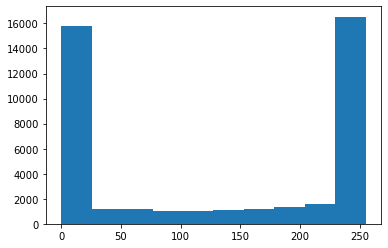

In [12]:
X_train_2D = np.reshape(X_train.values, (X_train.values.shape[0],)+(28,28))
print(X_train_2D.shape)
plt.hist(X_train_2D[:,14,14])

In [2]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=4)

knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

cv_scores_knn=cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=3)

#y_train_pred_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3)

#C_matrix_knn = confusion_matrix(y_train, y_train_pred_knn)

In [ ]:
cv_scores_knn

### KNN classifier with no pre-processing is 96.7% accurate - try scaling pixel values to break 97%

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train_scaled=StandardScaler().fit_transform(X_train.astype(np.float64))
print(X_train_scaled.shape,X_train.shape)
c=['pixel%i'%n for n in np.arange(0,784)]
print(c[-10:])

X_train_scaled=pd.DataFrame(X_train_scaled,columns=c)

X_train_scaled.head()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=4)

knn_clf.fit(X_train_scaled,y_train)



In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

cv_scores_knn=cross_val_score(knn_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
cv_scores_knn